In [1]:
#@title Environment setup
! pip install --upgrade xarray zarr gcsfs cftime nc-time-axis bokeh intake

     |████████████████████████████████| 737kB 5.6MB/s 
     |████████████████████████████████| 133kB 32.1MB/s 
     |████████████████████████████████| 296kB 17.3MB/s 
     |████████████████████████████████| 8.9MB 20.4MB/s 
     |████████████████████████████████| 1.5MB 43.2MB/s 
     |████████████████████████████████| 5.8MB 30.5MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
     |████████████████████████████████| 1.3MB 44.1MB/s 
     |████████████████████████████████| 2.2MB 44.7MB/s 
     |████████████████████████████████| 143kB 42.2MB/s 
     |████████████████████████████████| 296kB 45.1MB/s 
  Created wheel for bokeh: filename=bokeh-2.2.3-cp36-none-any.whl size=9296311 sha256=0c9c85a49afcd7783cdd0c61f7b4f4be357b63e8634cf3c81f82eda8702f27c1
  Stored in directory: /root/.cache/pip/wheels/dc/96/7b/9c9d48ed392511bc708e39580e18dc7a92f475795cd26b51bf
  Created wheel for asciitree: filename=asciitree-0.3.3-cp36-none-any.whl size=5038 sha256=687e08c9f0828f078300a915e48c95b30757

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import warnings
import matplotlib.pyplot as plt
import gcsfs
import intake

/HOME/ncs/miniconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
#@title Load the monthly CanESM5 temperature data from google cloud store
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

experiment_id = "historical" #@param {type:"string"}
source_id = 'CanESM5-CanOE' #@param {type:"string"}
variable_id = 'fgco2' #@param {type:"string"}
table_id = 'Omon' #@param {type:"string"}

canesm5_query = df.query("activity_id=='CMIP' & "\
                         f"table_id == '{table_id}' & "\
                         f"variable_id == '{variable_id}' & "\
                         f"experiment_id == '{experiment_id}' & "\
                         f"source_id == '{source_id}'")

# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

# stack the data into an xarray
canesm5 = []
for zstore in canesm5_query.zstore.values:
  mapper = gcs.get_mapper(zstore)
  temp = xr.open_zarr(mapper, consolidated=True)
  member_id = zstore.split('/')[7]
  temp['member_id'] = member_id
  canesm5.append(temp)

canesm5 = xr.concat(canesm5, dim='member_id')

In [4]:
fgco2_lim= canesm5.sel(time=slice('1980-01-01', '1985-12-31')).mean(dim='time')['fgco2']

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


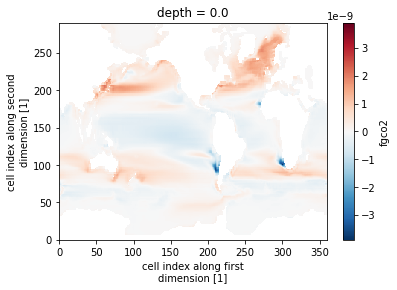

In [5]:
fgco2_lim.mean(dim='member_id').plot()

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


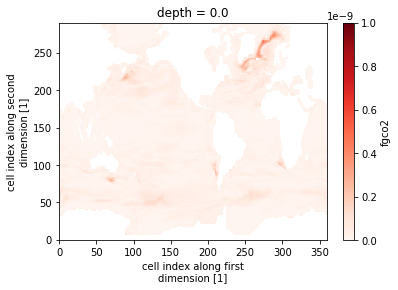

In [ ]:
fgco2_lim.std(dim='member_id').plot(vmin=0, vmax=1e-9, cmap='Reds')

In [ ]:
fgco2_std= canesm5.sel(time=slice('1980-01-01', '1985-12-31')).std(dim='time')['fgco2'].mean(dim='member_id').compute()

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


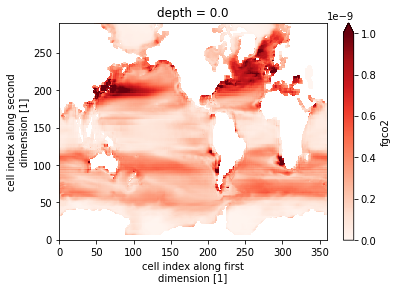

In [ ]:
fgco2_std.plot(vmin=0, vmax=1e-9, cmap='Reds')

In [ ]:
fgco2_std_ann = canesm5.sel(time=slice('1980-01-01', '1985-12-31')).resample(time='A').mean().std(dim='time')['fgco2'].mean(dim='member_id').compute()

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


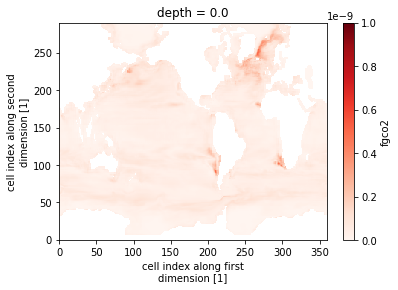

In [ ]:
fgco2_std_ann.plot(vmin=0, vmax=1e-9, cmap='Reds')

In [ ]:
canesm5

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 291, member_id: 3, time: 1980, vertices: 4)
Coordinates:
    time_bnds           (time, bnds) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
    longitude           (j, i) float64 73.5 74.5 75.5 76.5 ... 72.95 72.96 72.99
    latitude            (j, i) float64 -78.39 -78.39 -78.39 ... 50.23 50.01
    depth               float64 0.0
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * time                (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
  * member_id           (member_id) object 'r1i1p2f1' 'r2i1p2f1' 'r3i1p2f1'
Dimensions without coordinates: bnds, vertices
Data variables:
    fgco2               (member_id, time, j, i) float32 dask.array<chunksize=(1, 202, 291, 360), meta=np.ndarray>
    vertices_latitude   (member_id, j, i, vertices) float64 dask.array<chunksize=(1, 291, 360, 4), meta=np.ndarray>
    vertices_longitude  (member_id, j, i, vertices) float64 dask.array<chunksize=(1, 291, 360, 4), meta=np.ndarray>
Attributes:
    CCCma_model_hash:            932b659de600c6a0e94f619abaf9cc79eabcd337
    CCCma_parent_runid:          canoecpl-007
    CCCma_pycmor_hash:           3ecdc18eb7c1f7fbce0346850f41adf815d9fb66
    CCCma_runid:                 c2-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    YMDH_branch_time_in_parent:  5550:01:01:00
    activity_id:                 CMIP
    branch_method:               Spin-up documentation
    branch_time_in_child:        0.0
    branch_time_in_parent:       1350500.0
    cmor_version:                3.5.0
    contact:                     ec.cccma.info-info.ccmac.ec@canada.ca
    creation_date:               2019-12-11T18:56:41Z
    data_specs_version:          01.00.31
    experiment:                  all-forcing simulation of the recent past
    experiment_id:               historical
    external_variables:          areacello
    forcing_index:               1
    frequency:                   mon
    further_info_url:            https://furtherinfo.es-doc.org/CMIP6.CCCma.C...
    grid:                        ORCA1 tripolar grid, 1 deg with refinement t...
    grid_label:                  gn
    history:                     2019-12-11T18:56:41Z ;rewrote data to be con...
    initialization_index:        1
    institution:                 Canadian Centre for Climate Modelling and An...
    institution_id:              CCCma
    license:                     CMIP6 model data produced by The Government ...
    mip_era:                     CMIP6
    nominal_resolution:          100 km
    parent_activity_id:          CMIP
    parent_experiment_id:        piControl
    parent_mip_era:              CMIP6
    parent_source_id:            CanESM5-CanOE
    parent_time_units:           days since 1850-01-01 0:0:0.0
    parent_variant_label:        r1i1p2f1
    physics_index:               2
    product:                     model-output
    realization_index:           1
    realm:                       ocnBgchem
    references:                  Geoscientific Model Development Special issu...
    source:                      CanESM5-CanOE (2019): \naerosol: interactive...
    source_id:                   CanESM5-CanOE
    source_type:                 AOGCM
    status:                      2020-02-06;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:              none
    sub_experiment_id:           none
    table_id:                    Omon
    table_info:                  Creation Date:(24 July 2019) MD5:c93735846d6...
    title:                       CanESM5-CanOE output prepared for CMIP6
    tracking_id:                 hdl:21.14100/57c166ae-7582-4675-b2c3-3b828c9...
    variable_id:                 fgco2
    variant_label:               r1i1p2f1
    version:                     v20190429